In [2]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import random
import PIL

In [3]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [52]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.5),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8),],0.2),
    transforms.RandomApply([transforms.RandomRotation(degrees=(0,120)),],0.3),
    transforms.RandomAdjustSharpness(0.8, p=0.3),
    transforms.RandomPerspective(distortion_scale=0.6, p=0.3)
])

In [5]:
data=torchvision.datasets.ImageFolder("/mnt/sda/FaceRecog/Faces for Training/cropped_faces",transform=transform)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/mnt/sda/FaceRecog/Faces for Training/cropped_faces'

In [6]:
device=torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [7]:
model=torchvision.models.vgg16(pretrained=True)

C:\Users\kashy\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kashy\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for i in model.parameters():
    i.requires_grad=False

In [9]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
for i in model.parameters():
    i.requires_grad=False

In [42]:
class no(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x

In [43]:
model.avgpool=nn.AdaptiveAvgPool2d((1,1))
model.classifier=nn.Sequential(
    
        nn.Linear(512,256),
        nn.ReLU(inplace=True),
        
        nn.Linear(256,128)
    
    )

In [44]:
net=model.to(device)

In [45]:
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [46]:

class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        super().__init__()
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

       
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [47]:
sdata=SiameseNetworkDataset(data,transform)

In [48]:
data_loader=DataLoader(sdata,64,shuffle=True,num_workers=2)

torch.Size([3, 224, 224])
tensor([0.])


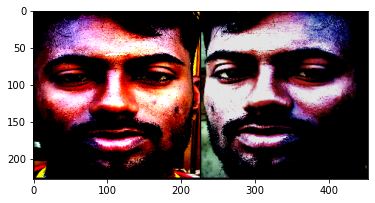

In [51]:
for i,j,l in data_loader:
    plt.imshow(np.transpose(torchvision.utils.make_grid([i[0],j[0]], padding=2, normalize=True).cpu(),(1,2,0)))
    print(i[0].shape)
    print(l[0])
    break

In [52]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
       
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [63]:

criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.0001 )

In [54]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(30):


    for i, (img0, img1, label) in enumerate(data_loader, 0):

    
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)

        
        optimizer.zero_grad()

        
        output1 = net(img0)
        output2=net(img1)

        
        loss_contrastive = criterion(output1, output2, label)

       
        loss_contrastive.backward()

        
        optimizer.step()

        
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



Epoch number 0
 Current loss 1.0734636783599854

Epoch number 0
 Current loss 0.9985339641571045

Epoch number 0
 Current loss 0.9750967621803284

Epoch number 0
 Current loss 0.9082872867584229

Epoch number 0
 Current loss 0.9338325262069702

Epoch number 0
 Current loss 0.8276564478874207

Epoch number 0
 Current loss 1.0724925994873047

Epoch number 0
 Current loss 0.7576896548271179

Epoch number 0
 Current loss 0.8050191402435303

Epoch number 0
 Current loss 0.8247227072715759

Epoch number 0
 Current loss 0.8716347217559814

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 0
 Current loss nan

Epoch number 1
 Current loss nan

Epoch number 1
 Current loss nan

Epoch number 1
 Current loss nan

Epoch number 1
 Current loss nan

Epoch number 1
 Cur

Epoch number 11
 Current loss nan

Epoch number 11
 Current loss nan

Epoch number 11
 Current loss nan

Epoch number 11
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 12
 Current loss nan

Epoch number 13
 Current loss nan

Epoch number 13
 Current loss nan

Epoch number 13
 Current loss nan

Epoch number 13
 Current loss nan

Epoch number 13
 Cur

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/secquraise/anaconda3/lib/python3.9/multiprocessing/connection.py", line 41

KeyboardInterrupt: 

In [43]:
torch.cuda.is_available()

False

In [ ]:
torch.save(net,"fine_tune_model3.pt")

In [56]:
mtcnn=MTCNN()

In [57]:
image=Image.open( '/mnt/sda/FaceRecog/Faces for Training/Face Data for Training - Multi-Face/ADR-60001/ADR-60001-001.jpg')
b=mtcnn.detect(image)
b=b[0][0]
x1, x2, y1, y2 = int(b[0]), int(b[1]), int(b[2]), int(b[3])
image=image.crop((x1,x2,y1,y2))
# image.show()
image_tensor=transform(image).float()
image_tensor=image_tensor.unsqueeze_(0)

input=torch.autograd.Variable(image_tensor)

In [59]:
image1=Image.open( '/mnt/sda/FaceRecog/Faces for Training/Face Data for Training - Multi-Face/ADR-60001/ADR-60001-003.jpg' )
b=mtcnn.detect(image1)
b=b[0][0]
x1, x2, y1, y2 = int(b[0]), int(b[1]), int(b[2]), int(b[3])
image1=image1.crop((x1,x2,y1,y2))
image_tensor1=transform(image1).float()
image_tensor1=image_tensor1.unsqueeze_(0)

input1=torch.autograd.Variable(image_tensor1)

In [60]:
a1=net(input)

In [61]:
a2=net(input1)

In [62]:
torch.dist(a1,a2)

tensor(nan, grad_fn=<DistBackward0>)

In [2]:
torch.cuda.is_available()

False

In [11]:
img=PIL.Image.open("D:\\si\\TS1116_2022-08-09 19_31_57.878_0.47.jpg")

In [14]:
img=transform(img)

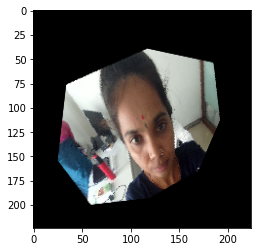

In [80]:
img=PIL.Image.open("D:\\si\\TS1116_2022-08-09 19_31_57.878_0.47.jpg")
img=transform(img)

plt.imshow(np.transpose(img,(1,2,0)))